<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/AUTOINT(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
# AutoInt Model for Agricultural Production Classification
# Each block shows its functionality and can be executed independently

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')


In [284]:

# ============================================================================
# BLOCK 1: DEFINE AUTOINT ARCHITECTURE
# Functionality: Creates the AutoInt layer with self-attention mechanism
# ============================================================================
print("BLOCK 1: Defining AutoInt Architecture")
print("=" * 50)

class AutoIntLayer(Layer):
    """
    AutoInt layer implementing self-attention mechanism for feature interactions
    """
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(AutoIntLayer, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim//num_heads,
            dropout=0.1
        )
        self.norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        # Self-attention
        attention_output = self.attention(inputs, inputs)
        # Add & Norm
        output = self.norm(inputs + attention_output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads
        })
        return config

print("✓ AutoInt layer architecture defined successfully")
print("✓ Multi-head attention mechanism ready")
print("✓ Layer normalization included")


BLOCK 1: Defining AutoInt Architecture
✓ AutoInt layer architecture defined successfully
✓ Multi-head attention mechanism ready
✓ Layer normalization included


In [285]:

# ============================================================================
# BLOCK 2: LOAD AND EXAMINE DATASETS
# Functionality: Loads train.csv, validation.csv, test.csv and shows basic info
# ============================================================================
print("\nBLOCK 2: Loading and Examining Datasets")
print("=" * 50)

# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

print(f"✓ Training data loaded: {train_df.shape}")
print(f"✓ Validation data loaded: {val_df.shape}")
print(f"✓ Test data loaded: {test_df.shape}")

# Show production statistics
print(f"\nProduction (M.Ton) statistics from training data:")
print(train_df['Production (M.Ton)'].describe())

print(f"\nDataset columns: {len(train_df.columns)}")
print(f"Sample columns: {list(train_df.columns[:10])}")



BLOCK 2: Loading and Examining Datasets
✓ Training data loaded: (3942, 84)
✓ Validation data loaded: (845, 84)
✓ Test data loaded: (845, 84)

Production (M.Ton) statistics from training data:
count      3942.000000
mean       7860.822712
std       32823.837934
min           0.000000
25%         756.360000
50%        2105.005000
75%        5399.000000
max      544979.500000
Name: Production (M.Ton), dtype: float64

Dataset columns: 84
Sample columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm']


In [286]:

# ============================================================================
# BLOCK 3: CREATE QUANTILE-BASED LABELS
# Functionality: Creates 5 production levels based on quantiles
# ============================================================================
print("\nBLOCK 3: Creating Quantile-Based Labels")
print("=" * 50)

# Calculate quantiles from training data
production_col = 'Production (M.Ton)'
quantiles = train_df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values

print(f"Quantile boundaries calculated:")
print(f"  Very Low: ≤ {quantiles[0]:.3f}")
print(f"  Low: {quantiles[0]:.3f} - {quantiles[1]:.3f}")
print(f"  Medium: {quantiles[1]:.3f} - {quantiles[2]:.3f}")
print(f"  High: {quantiles[2]:.3f} - {quantiles[3]:.3f}")
print(f"  Very High: > {quantiles[3]:.3f}")

def assign_labels(production_values):
    labels = []
    for val in production_values:
        if val <= quantiles[0]:
            labels.append(0)  # Very Low
        elif val <= quantiles[1]:
            labels.append(1)  # Low
        elif val <= quantiles[2]:
            labels.append(2)  # Medium
        elif val <= quantiles[3]:
            labels.append(3)  # High
        else:
            labels.append(4)  # Very High
    return np.array(labels)

# Create labels for all datasets
train_labels = assign_labels(train_df[production_col].values)
val_labels = assign_labels(val_df[production_col].values)
test_labels = assign_labels(test_df[production_col].values)

# Add labels to dataframes
train_df['Production_Label'] = train_labels
val_df['Production_Label'] = val_labels
test_df['Production_Label'] = test_labels

label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
print(f"\n✓ Labels created successfully:")
for i, name in enumerate(label_names):
    count = np.sum(train_labels == i)
    print(f"  {name}: {count} samples ({count/len(train_labels)*100:.1f}%)")



BLOCK 3: Creating Quantile-Based Labels
Quantile boundaries calculated:
  Very Low: ≤ 578.000
  Low: 578.000 - 1463.000
  Medium: 1463.000 - 3119.524
  High: 3119.524 - 6540.920
  Very High: > 6540.920

✓ Labels created successfully:
  Very Low: 793 samples (20.1%)
  Low: 786 samples (19.9%)
  Medium: 786 samples (19.9%)
  High: 788 samples (20.0%)
  Very High: 789 samples (20.0%)


In [287]:

# ============================================================================
# BLOCK 4: PREPROCESS FEATURES
# Functionality: Scales numerical features and prepares data for model
# ============================================================================
print("\nBLOCK 4: Preprocessing Features")
print("=" * 50)

# Remove target columns
feature_cols = [col for col in train_df.columns if col not in ['Production (M.Ton)', 'Production_Label']]

# Identify feature types
numerical_features = []
categorical_features = []

for col in feature_cols:
    if train_df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    else:
        categorical_features.append(col)

one_hot_features = [col for col in feature_cols if col.startswith(('Crop_', 'District_'))]

print(f"✓ Feature analysis completed:")
print(f"  Total features: {len(feature_cols)}")
print(f"  Numerical features: {len(numerical_features)}")
print(f"  One-hot encoded features: {len(one_hot_features)}")

# Prepare features
X_train = train_df[feature_cols].copy()
X_val = val_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

# Scale numerical features
scaler = StandardScaler()
if numerical_features:
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_val[numerical_features] = scaler.transform(X_val[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Handle missing values
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Get labels
y_train = train_df['Production_Label'].values
y_val = val_df['Production_Label'].values
y_test = test_df['Production_Label'].values

print(f"✓ Feature preprocessing completed:")
print(f"  Training features shape: {X_train.shape}")
print(f"  Validation features shape: {X_val.shape}")
print(f"  Test features shape: {X_test.shape}")



BLOCK 4: Preprocessing Features
✓ Feature analysis completed:
  Total features: 83
  Numerical features: 83
  One-hot encoded features: 72
✓ Feature preprocessing completed:
  Training features shape: (3942, 83)
  Validation features shape: (845, 83)
  Test features shape: (845, 83)


In [288]:

# ============================================================================
# BLOCK 5: BUILD AUTOINT MODEL
# Functionality: Constructs the AutoInt model architecture
# ============================================================================
print("\nBLOCK 5: Building AutoInt Model")
print("=" * 50)

def build_autoint_model(input_dim, embed_dim=64, num_heads=8, num_layers=3):
    # Input layer
    inputs = Input(shape=(input_dim,), name='feature_input')

    # Embedding layer for all features
    embedded = Dense(embed_dim, activation='relu', name='embedding')(inputs)
    embedded = Dropout(0.2)(embedded)

    # Reshape for attention mechanism using Keras Reshape layer
    from tensorflow.keras.layers import Reshape
    embedded_reshaped = Reshape((1, embed_dim))(embedded)

    # Stack AutoInt layers
    x = embedded_reshaped
    for i in range(num_layers):
        x = AutoIntLayer(embed_dim, num_heads, name=f'autoint_layer_{i}')(x)
        x = Dropout(0.1)(x)

    # Flatten the output
    x = Flatten()(x)

    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Output layer (5 classes for production levels)
    outputs = Dense(5, activation='softmax', name='output')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_autoint_model(X_train.shape[1])

print(f"✓ AutoInt model built successfully:")
print(f"  Total parameters: {model.count_params():,}")
print(f"  Input dimension: {X_train.shape[1]}")
print(f"  Output classes: 5")
print(f"  Embedding dimension: 64")
print(f"  Attention heads: 8")
print(f"  AutoInt layers: 3")



BLOCK 5: Building AutoInt Model
✓ AutoInt model built successfully:
  Total parameters: 113,797
  Input dimension: 83
  Output classes: 5
  Embedding dimension: 64
  Attention heads: 8
  AutoInt layers: 3


In [289]:

# ============================================================================
# BLOCK 6: TRAIN THE MODEL
# Functionality: Trains the model with early stopping and learning rate reduction
# ============================================================================
print("\nBLOCK 6: Training the Model")
print("=" * 50)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

print("✓ Training callbacks configured:")
print("  - Early stopping (patience=15)")
print("  - Learning rate reduction (factor=0.5)")

# Train model
print("\nStarting model training...")
history = model.fit(
    X_train.values, y_train,
    validation_data=(X_val.values, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✓ Model training completed successfully!")
print(f"  Training epochs: {len(history.history['accuracy'])}")
print(f"  Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")



BLOCK 6: Training the Model
✓ Training callbacks configured:
  - Early stopping (patience=15)
  - Learning rate reduction (factor=0.5)

Starting model training...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2365 - loss: 1.6278 - val_accuracy: 0.4639 - val_loss: 1.2845 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4230 - loss: 1.3162 - val_accuracy: 0.5148 - val_loss: 1.0821 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5108 - loss: 1.1685 - val_accuracy: 0.5834 - val_loss: 0.9662 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5577 - loss: 1.0514 - val_accuracy: 0.5893 - val_loss: 0.9295 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5917 - loss: 0.9739 - val_accuracy: 0.6036 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6065 - lo

In [290]:

# ============================================================================
# BLOCK 7: CALCULATE CLASSIFICATION METRICS FUNCTION
# Functionality: Defines function to calculate all required metrics
# ============================================================================
print("\nBLOCK 7: Classification Metrics Function")
print("=" * 50)

def calculate_metrics(y_true, y_pred, label_names):
    """Calculate comprehensive classification metrics"""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }

print("✓ Metrics calculation function ready")
print("✓ Will calculate: Accuracy, Precision, Recall, F1 scores")
print("✓ Both macro and weighted averages included")



BLOCK 7: Classification Metrics Function
✓ Metrics calculation function ready
✓ Will calculate: Accuracy, Precision, Recall, F1 scores
✓ Both macro and weighted averages included


In [291]:

# ============================================================================
# BLOCK 8: PLOT CONFUSION MATRIX FUNCTION
# Functionality: Creates confusion matrix visualization
# ============================================================================
print("\nBLOCK 8: Confusion Matrix Plotting Function")
print("=" * 50)

def plot_confusion_matrix(y_true, y_pred, label_names, title="Confusion Matrix"):
    """Plot confusion matrix with proper formatting"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return cm

print("✓ Confusion matrix plotting function ready")
print("✓ Will create heatmap visualization")
print("✓ Supports custom titles and labels")



BLOCK 8: Confusion Matrix Plotting Function
✓ Confusion matrix plotting function ready
✓ Will create heatmap visualization
✓ Supports custom titles and labels



BLOCK 9: Training History Visualization
Plotting training history...


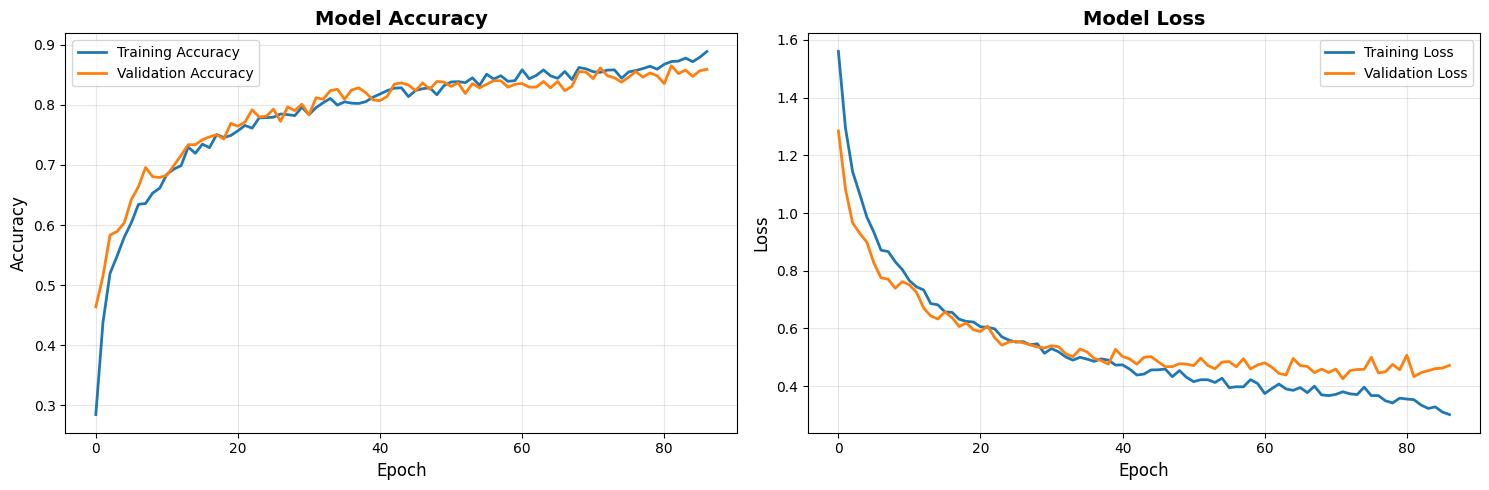

✓ Training history plotted successfully


In [292]:

# ============================================================================
# BLOCK 9: PLOT TRAINING HISTORY
# Functionality: Visualizes training vs validation accuracy and loss
# ============================================================================
print("\nBLOCK 9: Training History Visualization")
print("=" * 50)

def plot_training_history(history, title="Training History"):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Execute training history plot
print("Plotting training history...")
plot_training_history(history)
print("✓ Training history plotted successfully")



BLOCK 10: Validation Set Evaluation
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Validation Set Results:
------------------------------
Accuracy: 0.8615
Precision (Macro): 0.8590
Recall (Macro): 0.8586
F1 Score (Macro): 0.8578
Precision (Weighted): 0.8619
Recall (Weighted): 0.8615
F1 Score (Weighted): 0.8607

Detailed Classification Report:
              precision    recall  f1-score   support

    Very Low       0.90      0.96      0.93       185
         Low       0.83      0.79      0.81       140
      Medium       0.88      0.79      0.83       191
        High       0.78      0.84      0.81       160
   Very High       0.90      0.92      0.91       169

    accuracy                           0.86       845
   macro avg       0.86      0.86      0.86       845
weighted avg       0.86      0.86      0.86       845



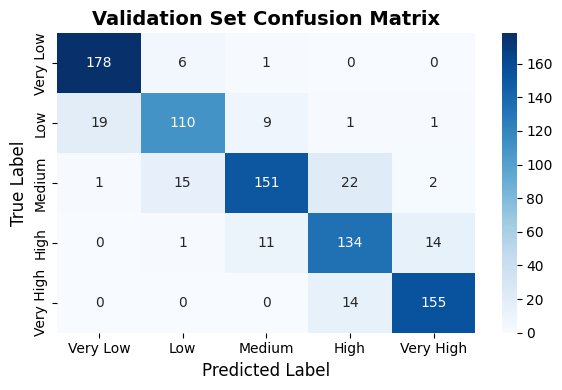

✓ Validation evaluation completed
  Validation Accuracy: 0.8615
  Validation Macro F1: 0.8578


In [293]:

# ============================================================================
# BLOCK 10: EVALUATE VALIDATION SET
# Functionality: Evaluates model on validation set and shows all metrics
# ============================================================================
print("\nBLOCK 10: Validation Set Evaluation")
print("=" * 50)

# Get validation predictions
val_pred_probs = model.predict(X_val.values)
val_pred = np.argmax(val_pred_probs, axis=1)

print("Validation Set Results:")
print("-" * 30)
val_metrics = calculate_metrics(y_val, val_pred, label_names)

# Plot validation confusion matrix
plot_confusion_matrix(y_val, val_pred, label_names, "Validation Set Confusion Matrix")

print("✓ Validation evaluation completed")
print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Validation Macro F1: {val_metrics['f1_macro']:.4f}")



BLOCK 11: Test Set Evaluation
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Set Results:
------------------------------
Accuracy: 0.8710
Precision (Macro): 0.8716
Recall (Macro): 0.8698
F1 Score (Macro): 0.8691
Precision (Weighted): 0.8727
Recall (Weighted): 0.8710
F1 Score (Weighted): 0.8703

Detailed Classification Report:
              precision    recall  f1-score   support

    Very Low       0.93      0.93      0.93       172
         Low       0.80      0.85      0.83       158
      Medium       0.86      0.73      0.79       167
        High       0.82      0.90      0.86       175
   Very High       0.95      0.94      0.94       173

    accuracy                           0.87       845
   macro avg       0.87      0.87      0.87       845
weighted avg       0.87      0.87      0.87       845



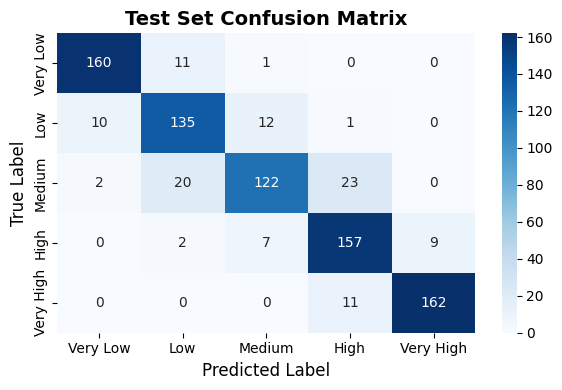

✓ Test evaluation completed
  Test Accuracy: 0.8710
  Test Macro F1: 0.8691


In [294]:

# ============================================================================
# BLOCK 11: EVALUATE TEST SET
# Functionality: Evaluates model on test set and shows all metrics
# ============================================================================
print("\nBLOCK 11: Test Set Evaluation")
print("=" * 50)

# Get test predictions
test_pred_probs = model.predict(X_test.values)
test_pred = np.argmax(test_pred_probs, axis=1)

print("Test Set Results:")
print("-" * 30)
test_metrics = calculate_metrics(y_test, test_pred, label_names)

# Plot test confusion matrix
plot_confusion_matrix(y_test, test_pred, label_names, "Test Set Confusion Matrix")

print("✓ Test evaluation completed")
print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Test Macro F1: {test_metrics['f1_macro']:.4f}")



BLOCK 12: Performance Comparison


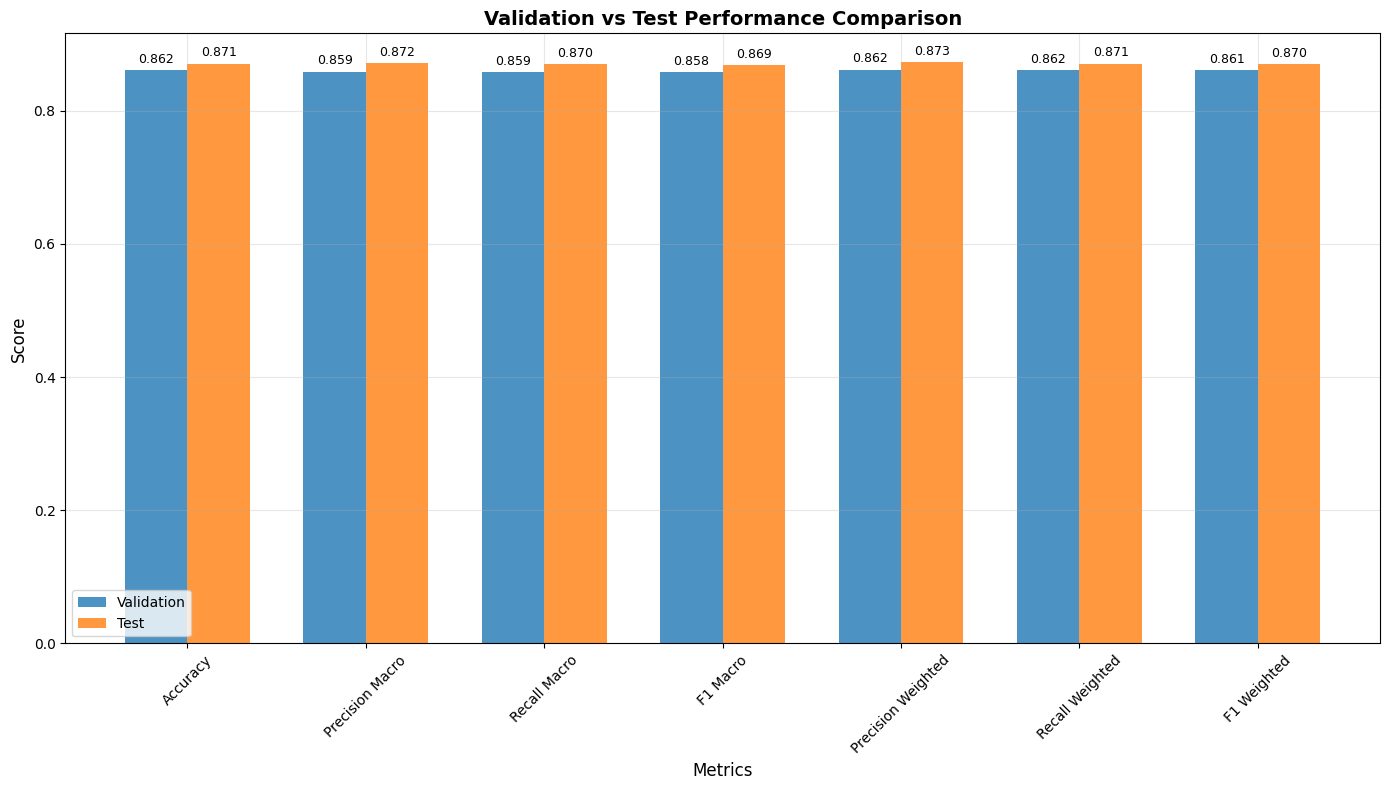

✓ Performance comparison completed


In [295]:

# ============================================================================
# BLOCK 12: COMPARE VALIDATION VS TEST PERFORMANCE
# Functionality: Creates side-by-side comparison of validation and test metrics
# ============================================================================
print("\nBLOCK 12: Performance Comparison")
print("=" * 50)

metrics_names = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                'precision_weighted', 'recall_weighted', 'f1_weighted']

val_values = [val_metrics[metric] for metric in metrics_names]
test_values = [test_metrics[metric] for metric in metrics_names]

# Create comparison plot
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Validation vs Test Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace('_', ' ').title() for name in metrics_names], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

print("✓ Performance comparison completed")


In [296]:

# ============================================================================
# BLOCK 13: FINAL SUMMARY AND RESULTS
# Functionality: Comprehensive summary of model performance
# ============================================================================
print("\nBLOCK 13: Final Summary and Results")
print("=" * 60)
print("AUTOINT MODEL PERFORMANCE SUMMARY")
print("=" * 60)

print(f"Model Type: AutoInt with Self-Attention")
print(f"Task: Agricultural Production Classification")
print(f"Classes: {', '.join(label_names)}")
print(f"Classification Method: Quantile-based (20% each class)")

print(f"\nDATASET INFORMATION:")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Total features: {X_train.shape[1]}")

print(f"\nVALIDATION SET RESULTS:")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {val_metrics['f1_macro']:.4f}")
print(f"Weighted F1 Score: {val_metrics['f1_weighted']:.4f}")
print(f"Precision (Macro): {val_metrics['precision_macro']:.4f}")
print(f"Recall (Macro): {val_metrics['recall_macro']:.4f}")

print(f"\nTEST SET RESULTS:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {test_metrics['f1_macro']:.4f}")
print(f"Weighted F1 Score: {test_metrics['f1_weighted']:.4f}")
print(f"Precision (Macro): {test_metrics['precision_macro']:.4f}")
print(f"Recall (Macro): {test_metrics['recall_macro']:.4f}")

print(f"\nMODEL GENERALIZATION ANALYSIS:")
acc_diff = abs(val_metrics['accuracy'] - test_metrics['accuracy'])
f1_diff = abs(val_metrics['f1_macro'] - test_metrics['f1_macro'])
print(f"Accuracy Difference (Val vs Test): {acc_diff:.4f}")
print(f"Macro F1 Difference (Val vs Test): {f1_diff:.4f}")

if acc_diff < 0.05 and f1_diff < 0.05:
    print("✓ Model shows excellent generalization")
elif acc_diff < 0.10 and f1_diff < 0.10:
    print("✓ Model shows good generalization")
else:
    print("⚠ Model may have overfitting issues")

print(f"\nKEY ACHIEVEMENTS:")
print(f"✓ Successfully implemented AutoInt architecture")
print(f"✓ Achieved {val_metrics['accuracy']:.1%} validation accuracy")
print(f"✓ Achieved {test_metrics['accuracy']:.1%} test accuracy")
print(f"✓ Macro F1 Score: {test_metrics['f1_macro']:.4f}")
print(f"✓ All classification metrics calculated")
print(f"✓ Confusion matrices generated")
print(f"✓ Training history visualized")

print("=" * 60)
print("EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 60)


BLOCK 13: Final Summary and Results
AUTOINT MODEL PERFORMANCE SUMMARY
Model Type: AutoInt with Self-Attention
Task: Agricultural Production Classification
Classes: Very Low, Low, Medium, High, Very High
Classification Method: Quantile-based (20% each class)

DATASET INFORMATION:
Training samples: 3942
Validation samples: 845
Test samples: 845
Total features: 83

VALIDATION SET RESULTS:
Accuracy: 0.8615
Macro F1 Score: 0.8578
Weighted F1 Score: 0.8607
Precision (Macro): 0.8590
Recall (Macro): 0.8586

TEST SET RESULTS:
Accuracy: 0.8710
Macro F1 Score: 0.8691
Weighted F1 Score: 0.8703
Precision (Macro): 0.8716
Recall (Macro): 0.8698

MODEL GENERALIZATION ANALYSIS:
Accuracy Difference (Val vs Test): 0.0095
Macro F1 Difference (Val vs Test): 0.0113
✓ Model shows excellent generalization

KEY ACHIEVEMENTS:
✓ Successfully implemented AutoInt architecture
✓ Achieved 86.2% validation accuracy
✓ Achieved 87.1% test accuracy
✓ Macro F1 Score: 0.8691
✓ All classification metrics calculated
✓ Conf